# Plastic Simulation

Please read the notebook on [Hardwall Simulation](Hardwall_Simulation.ipynb) before. 


The method is described in 

Weber, B. et al. Molecular probes reveal deviations from Amontons’ law in multi-asperity frictional contacts. Nature Communications 9, 888 (2018).


In [7]:
import numpy as np
import matplotlib.pyplot as plt

from SurfaceTopography import Topography, PlasticTopography
from ContactMechanics import FreeFFTElasticHalfSpace
from ContactMechanics.Factory import make_system
from ContactMechanics.Tools.Logger import screen

## Prepare Geometry

In [8]:
nx, ny = 128,128

sx = 0.005 # mm
sy = 0.005 # mm

x = np.arange(0, nx).reshape(-1,1 ) * sx/nx - sx / 2
y = np.arange(0, ny).reshape(1,-1 ) * sy/ny - sy / 2

topography= Topography(- np.sqrt(x**2 + y**2 ) *0.05, physical_sizes=(sx, sy) )


Text(0, 0.5, 'y (mm)')

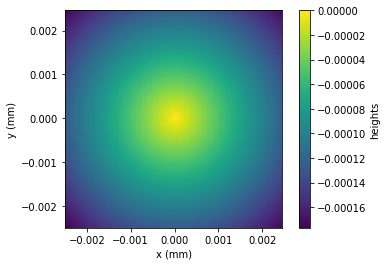

In [9]:
fig, ax = plt.subplots()
plt.colorbar(ax.pcolormesh(x * np.ones_like(y), y * np.ones_like(x), topography.heights()), label = "heights")
ax.set_aspect(1)
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")

Text(0, 0.5, 'heights (mm)')

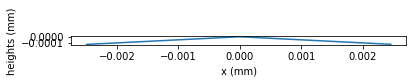

In [10]:
fig, ax = plt.subplots()
ax.plot(x, topography.heights()[:, ny//2])
ax.set_aspect(1)
ax.set_xlabel("x (mm)")
ax.set_ylabel("heights (mm)")

## Material Properties

In [11]:
Es = 230000 # MPa
hardness = 6000 # MPa

## setup system

the `make_system` automatically knows it has to do a plastic simulation if we pass a `PlasticTopogaraphy`

In [12]:
system = make_system(
            substrate = FreeFFTElasticHalfSpace(nb_grid_pts=topography.nb_grid_pts, young=Es, physical_sizes=topography.physical_sizes), 
            surface= PlasticTopography(topography=topography, hardness=hardness)
           )

#### loading history

In [13]:
external_forces = [0.001, 0.005,0.01, 0.02, 0.01, 0.005, 0.001]

#### optional: provide an initial contition
provide initial disp that is nonzero because otherwise the optimizer will begin with full contact area, 
what is far from the solution in this case

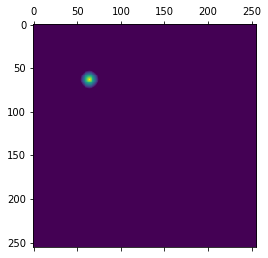

In [14]:
penetration = 0.00002
disp0 = np.zeros(system.substrate.nb_domain_grid_pts)
disp0[system.surface.subdomain_slices] = system.surface.heights() + penetration
disp0 = np.where(disp0 > 0, disp0, 0)
plt.matshow(disp0)

### Simulate

In [15]:
# prepare empty arrays to contain results
offsets = []
plastic_areas = []
contact_areas = []
forces = np.zeros((len(external_forces), *topography.nb_grid_pts)) # forces[timestep,...]: array of forces for each gridpoint
elastic_displacements = np.zeros((len(external_forces), *topography.nb_grid_pts))
plastified_topographies = []

i=0
for external_force in external_forces:
    sol = system.minimize_proxy(external_force=external_force, #load controlled
                                #mixfac = 1e-4,
                                disp0=disp0,
                                pentol=1e-10, # for the default value I had some spiky pressure fields during unloading
                                logger=screen) # display informations about each iteration
    assert sol.success
    disp0 = system.disp
    offsets.append(system.offset)
    plastic_areas.append(system.surface.plastic_area)
    contact_areas.append(system.compute_contact_area())
    
    plastified_topographies.append(system.surface.squeeze())
    #system.surface=PlasticTopography(topography=topography, hardness=hardness) # reset surface
    forces[i,...] = system.force
    elastic_displacements[i, ...] = system.disp[system.surface.subdomain_slices]
    
    i+=1
    #print(np.max(system.surface.plastic_displ))
    #print(np.min(system.surface.plastic_displ))

# {constrained_conjugate_gradients}: maxiter = 100000
# {constrained_conjugate_gradients}: pentol = 1e-10
#            1:status      2:it                3:area          4:frac. area         5:total force              6:offset
                   cg         1    2.530000000000e+02    1.544189453125e-02    1.000000000000e-03    2.000000000000e-05
                   cg         2    2.530000000000e+02    1.544189453125e-02    1.000000000000e-03    1.891263726560e-05
                   cg         3    1.610000000000e+02    9.826660156250e-03    1.000000000000e-03    1.839734044954e-05
                   cg         4    1.370000000000e+02    8.361816406250e-03    1.000000000000e-03    1.842016265214e-05
                   cg         5    1.290000000000e+02    7.873535156250e-03    1.000000000000e-03    1.847386454625e-05
                   cg         6    1.210000000000e+02    7.385253906250e-03    1.000000000000e-03    1.846842056939e-05
                   cg         7    1.210000000000e+02 

## plot pressure distributions and deformed profiles

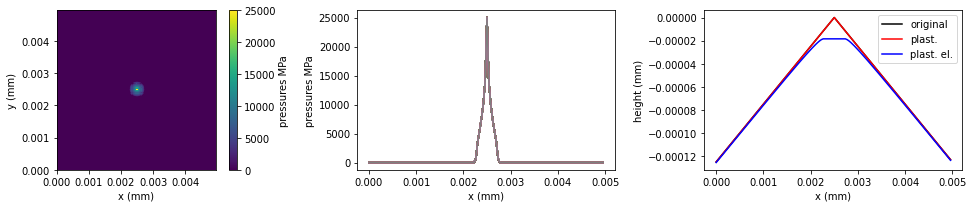

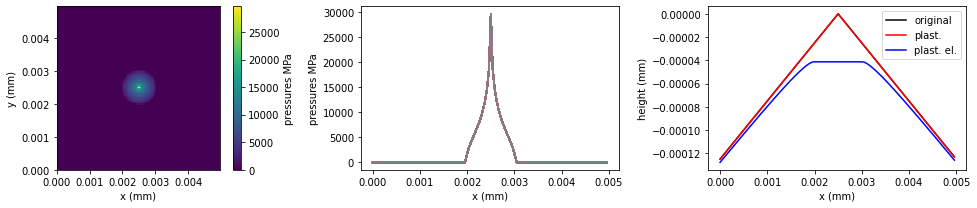

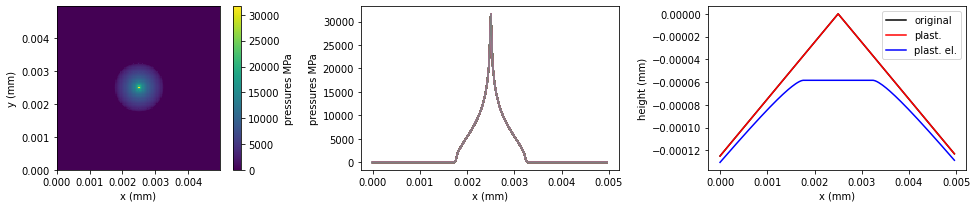

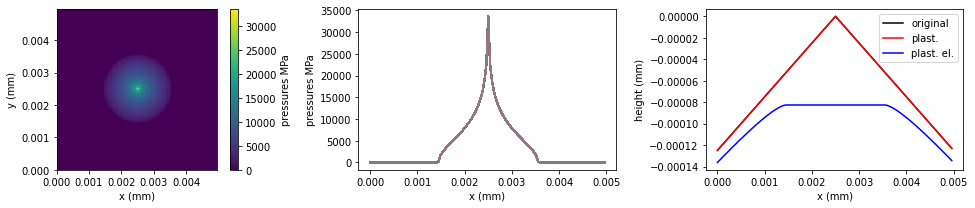

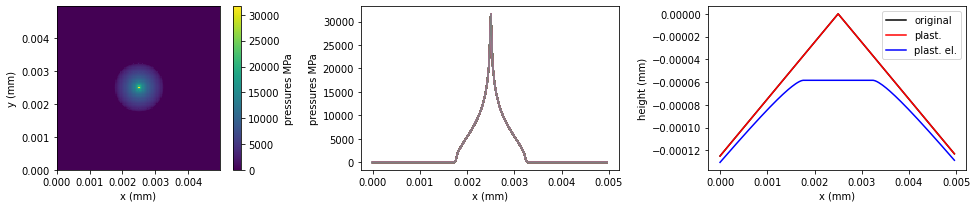

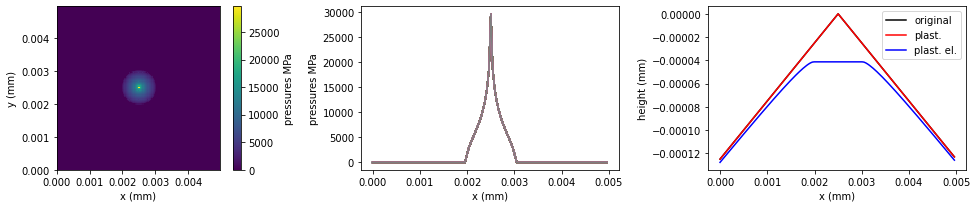

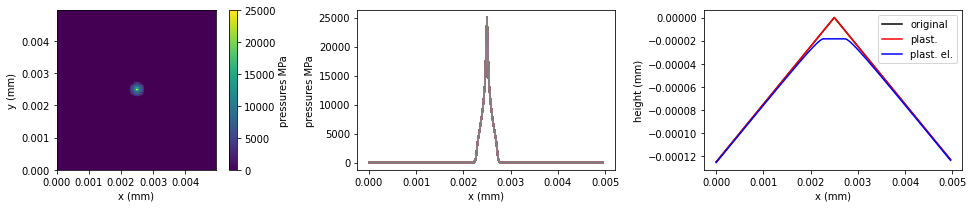

In [16]:
for i in range(len(external_forces)):
    
    fig, (axf, axfcut, axtopcut) = plt.subplots(1,3, figsize=(14,3))
    
    axf.set_xlabel("x (mm)")
    axf.set_ylabel("y (mm)")
        
    axfcut.plot(system.surface.positions()[0], forces[i, :, ny//2]/ system.area_per_pt)
    axfcut.set_xlabel("x")
    axfcut.set_ylabel("pressures MPa")
    
    for a in (axfcut, axtopcut):
        a.set_xlabel("x (mm)")
    axtopcut.set_ylabel("height (mm)")
    
    plt.colorbar(axf.pcolormesh(*system.surface.positions(), forces[i,...]/ system.area_per_pt), label="pressures MPa", ax = axf)
    axf.set_aspect(1)
    
    axtopcut.plot(system.surface.positions()[0][:,0], topography.heights()[:, ny//2], 
                  color="k", label = "original")
    axtopcut.plot(system.surface.positions()[0][:,0], plastified_topographies[i].heights()[:, ny//2], 
                  color = "r", label="plast.")
    axtopcut.plot(system.surface.positions()[0][:,0], plastified_topographies[i].heights()[:, ny//2] - elastic_displacements[i,:, ny//2], 
                  c="b", label="plast. el.")
    axtopcut.legend()
    
    fig.tight_layout()

## scalar quantities during loading

Text(0, 0.5, 'Force [N]')

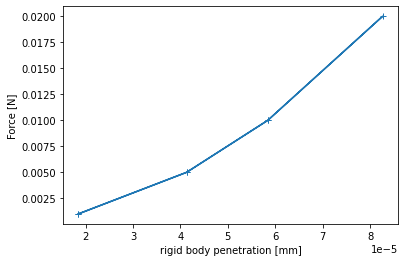

In [17]:
fig, ax = plt.subplots()

ax.plot(offsets, external_forces,"+-")
ax.set_xlabel("rigid body penetration [mm]")
ax.set_ylabel("Force [N]")

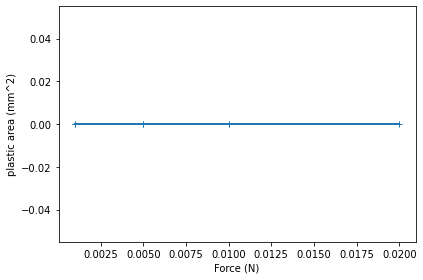

In [18]:
fig, ax = plt.subplots()

ax.plot(external_forces, plastic_areas, "-+")
ax.set_xlabel("Force (N)")
ax.set_ylabel("plastic area (mm^2)")
fig.tight_layout()

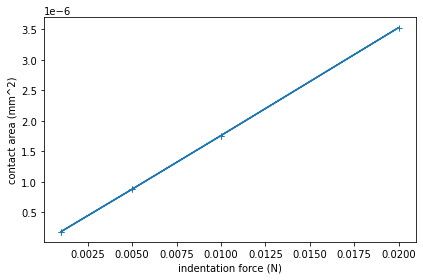

In [19]:
fig, ax = plt.subplots()

ax.plot(external_forces, contact_areas, "+-")
ax.set_xlabel("indentation force (N)")
ax.set_ylabel("contact area (mm^2)")
fig.tight_layout()